In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *
from test_function import test
from NN_classes import *

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

In [ ]:
# Import the data generated via matlab/simulink:

data_tensor, PSW_max = get_data(path = r"data\save_data_test5.csv", timesteps_from_data=0, skip_steps_start = 0,
                                 skip_steps_end = 0, drop_half_timesteps = False, normalise_s_w="minmax", rescale_p=False, num_inits=0)

# View an example of a simulation run
visualise(data_tensor, num_inits=9000)

In [37]:
# Multilayer perceptron
class MLP(nn.Module):
    
    def __init__(self, input_size=3, hidden_size = 6, l_num=1, output_size=2, act_fn="tanh"):
        super(MLP, self).__init__()
        
        if act_fn == "tanh":
            fn = nn.Tanh()
        else:
            fn = nn.ReLU()

        hidden_sizes = [hidden_size for x in range(l_num)]
        # Create a list to hold the layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(fn)
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(fn)
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        #Try final non linearity:
        #layers.append(nn.Tanh())
        
        # Use nn.Sequential to put together the layers
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        
        return self.network(x)         




In [32]:
#with future:
 
def train(loader, model, weight_decay, learning_rate=0.001, ws=0, batch_size=1):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
 
    model.train()
    total_loss = []
  
    for k, (x, x_last, y) in enumerate(loader):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)
        x_last = x_last.to(device)
        x_last = x_last.squeeze()
       #print(x.size(), y.size(), x_last.size())
        
        output = model(x)
        pred = x_last[:,1:] + output

        #print(output.size())
        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(pred, y[:,1:])
        loss.backward()
        optimizer.step()
 
        total_loss.append(loss.detach().cpu().numpy())
 
   # return the average error of the next step prediction
    return np.mean(total_loss)

torch.Size([2, 550, 3])


 21%|██        | 21/100 [00:03<00:14,  5.31it/s]

Epoch: 19, the average next step error was : loss_epoch
Average error over full trajectories: training data : 1.6741618718099156


 41%|████      | 41/100 [00:06<00:11,  5.13it/s]

Epoch: 39, the average next step error was : loss_epoch
Average error over full trajectories: training data : 3.593214321506384


 61%|██████    | 61/100 [00:10<00:07,  5.19it/s]

Epoch: 59, the average next step error was : loss_epoch
Average error over full trajectories: training data : 0.1614181289890315


 81%|████████  | 81/100 [00:13<00:03,  5.38it/s]

Epoch: 79, the average next step error was : loss_epoch
Average error over full trajectories: training data : 0.2063403646904802


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]

Epoch: 99, the average next step error was : loss_epoch
Average error over full trajectories: training data : 0.6442274626121154


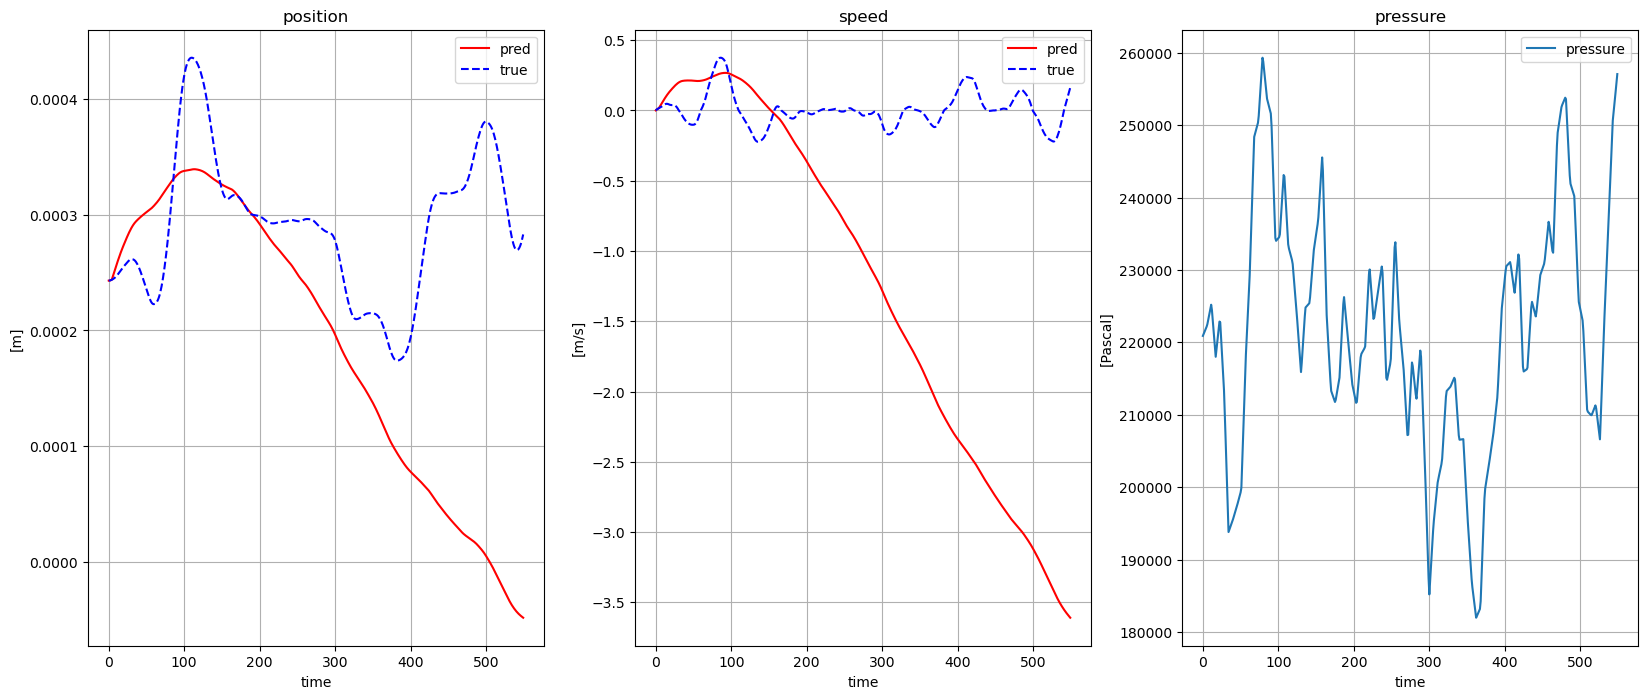

TRAINING FINISHED: Average error over full trajectories: training data : 0.17705182115483103


In [38]:

params =           {
                           "experiment_number" : 2,
                           "window_size" : 5,
                           "h_size" : 20,
                           "l_num" : 5,
                           "epochs" : 100,
                           "learning_rate" : 0.001,
                           "part_of_data" : 2, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.7,
                           "future_decay"  : 0.5,
                           "batch_size" : 10,
                           "future" : 10,
                           "cut_off_timesteps" : 0,
                           "drop_half_timesteps": True
                        }


# Initialize the LSTM model
model = MLP(input_size=3*params["window_size"], hidden_size = params["h_size"], l_num=params["l_num"], output_size=2, act_fn = "tanh").to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data1, PSW_max = get_data(path = "data\save_data_test5.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path = "data\Testruns_from_trajectory_generator_200.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data = torch.cat((input_data1, input_data2))
input_data = input_data1
print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set = CustomDataset_mlp(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"])#, pin_memory=True)

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(params["epochs"])):
    
    loss_epoch = train(train_loader, model, params["weight_decay"], learning_rate= params["learning_rate"], ws=params["window_size"], batch_size=params["batch_size"])
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%20 == 0:

        _,_, err_train = test(input_data, model, model_type = "mlp", window_size=params["window_size"], display_plots=False, num_of_inits = 20, set_rand_seed=True, physics_rescaling = PSW_max)

        average_traj_err_train.append(err_train)
        #average_traj_err_test.append(err_test)
        print(f"Epoch: {e}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
                #print(f"Average error over full trajectories: testing data : {err_test}")

_,_, err_train = test(input_data, model, model_type = "mlp", window_size=params["window_size"], display_plots=True, num_of_inits = 1, set_rand_seed=True, physics_rescaling = PSW_max)
#_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
print(f"TRAINING FINISHED: Average error over full trajectories: training data : {err_train}")
#print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

In [ ]:
# Save the model
#path = f"Ventil_trained_NNs\lstm_ws0.pth"
#torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = "working_networks\MLP.pth"


params =             {
                           "experiment_number" : 2,
                           "window_size" : 5,
                           "h_size" : 8,
                           "l_num" : 1,
                           "epochs" : 2000,
                           "learning_rate" : 0.001,
                           "part_of_data" : 0, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.8,
                           "future_decay"  : 0.5,
                           "batch_size" : 600,
                           "cut_off_timesteps" : 300,
                           "drop_half_timesteps": True,
                           "act_fn" : "relu"
                        }

input_data, PSW_max = get_data(path = "save_data_test4.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data2, PSW_max = get_data(path =  r"Testruns_from_trajectory_generator.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

input_data = torch.cat((input_data[-1:,:,:], input_data2[-1:,:,:]))


#np.random.seed(1234)

num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])
test_data = input_data[test_inits,:,:]
# Initialize the LSTM model

model = MLP(input_size=3*params["window_size"], hidden_size = params["h_size"], l_num=params["l_num"], output_size=2, act_fn = params["act_fn"]).to("cpu")
model.load_state_dict(torch.load(path, map_location=torch.device(device)))
                                 
train_data = input_data[train_inits,:,:]

#test_loss, test_loss_deriv, total_loss = test(test_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 8, test_inits=len(test_data), rand=False, PSW_max=PSW_max)

test_loss, test_loss_deriv, total_loss = test(input_data, model, model_type = "mlp", window_size=params["window_size"], display_plots=True, num_of_inits = 2, set_rand_seed=True, physics_rescaling = PSW_max)
print(total_loss)

In [ ]:
input_data.get_device()

In [ ]:
for i in range(60):
    x = input_data[i,:,:]
    plt.scatter(x[:,1], x[:,2])